In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 191 GB / percent used: 23.9 %


# Check model data

In [15]:
var = 't2m'
folder = 'ATM'
exp = 'clim-without-MVA9'

# Define zone
latlim=(10,50)
lonlim=(60,110)

label, units, cmap, levels = u.get_var_infos(var)

title_1 = 'clim-def'
root_1 = '/data/mlalande/gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZOR/PROD/clim'

title_2 = 'clim-without-MVA9'
root_2 = '/data/mlalande/gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZOR_v6.1.11_without_elevation_average/PROD/clim'

## Define paths and period

In [8]:
path_1 = root_1+'/clim-relief-def/'+folder+'/Analyse/TS_MO'
xr.open_mfdataset(path_1+'/*'+var+'.nc', combine='by_coords').time_counter.coords

Coordinates:
  * time_counter   (time_counter) object 1980-01-16 00:00:00 ... 1989-12-16 00:00:00
    time_centered  (time_counter) object dask.array<chunksize=(120,), meta=np.ndarray>

In [10]:
path_2 = root_2+'/clim-relief-def/'+folder+'/Analyse/TS_MO'
xr.open_mfdataset(path_2+'/*'+var+'.nc', combine='by_coords').time_counter.coords

Coordinates:
  * time_counter   (time_counter) object 1980-01-16 00:00:00 ... 1991-12-16 00:00:00
    time_centered  (time_counter) object dask.array<chunksize=(144,), meta=np.ndarray>

In [12]:
# Here the time doesn't make so much sense because the simulation are clim
period = slice('1982','1989')

## Load climatologies

In [14]:
model_1_clim = xr.open_mfdataset(path_1+'/*'+var+'.nc', combine='by_coords'
                                )[var].sel(time_counter=period).mean('time_counter') - 273.15
model_1_clim.load()

<xarray.DataArray 't2m' (lat: 143, lon: 144)>
array([[-17.587692, -17.587692, -17.587692, ..., -17.587692, -17.587692,
        -17.587692],
       [-16.736542, -16.770203, -16.756561, ..., -16.72226 , -16.72052 ,
        -16.744385],
       [-16.774536, -16.79602 , -16.822754, ..., -16.71521 , -16.72232 ,
        -16.735596],
       ...,
       [-46.101837, -45.89955 , -45.44066 , ..., -45.46042 , -45.18387 ,
        -45.511856],
       [-51.496323, -50.74562 , -51.2733  , ..., -53.173233, -53.130783,
        -51.417404],
       [-51.474396, -51.474396, -51.474396, ..., -51.474396, -51.474396,
        -51.474396]], dtype=float32)
Coordinates:
  * lat      (lat) float32 90.0 88.73239 87.46479 ... -87.46479 -88.73239 -90.0
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5

In [19]:
model_2_clim = xr.open_mfdataset(path_2+'/*'+var+'.nc', combine='by_coords'
                                )[var].sel(time_counter=period).mean('time_counter') - 273.15
model_2_clim.load()

<xarray.DataArray 't2m' (lat: 143, lon: 144)>
array([[-17.709457, -17.709457, -17.709457, ..., -17.709457, -17.709457,
        -17.709457],
       [-16.884155, -16.879303, -16.903198, ..., -16.841583, -16.857208,
        -16.861664],
       [-16.802063, -16.848755, -16.842102, ..., -16.744568, -16.757263,
        -16.766022],
       ...,
       [-46.434128, -46.3239  , -46.179153, ..., -45.484146, -45.271713,
        -45.6149  ],
       [-51.247467, -50.41617 , -50.40654 , ..., -52.833893, -52.452667,
        -51.530914],
       [-51.7014  , -51.7014  , -51.7014  , ..., -51.7014  , -51.7014  ,
        -51.7014  ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 90.0 88.73239 87.46479 ... -87.46479 -88.73239 -90.0
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5

# Load obs
## cru_ts4.00
More recent version available: https://crudata.uea.ac.uk/cru/data/hrg/  
-> pas évident à télécharger encore... les netCDF ne sont pas reconnus directement, je vais rester du coup sur la version 4.00 sur CICLAD

See: http://localhost:7227/notebooks/notebooks/CICLAD/Himalaya/CMIP6_IPSL_bias/Temperature.ipynb

In [16]:
obs_longname = 'CRU TS v. 4.00'
obs_name = 'CRU'

obs = xr.open_dataset('/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc').sel(time=period).tmp
obs_clim = u.clim(obs, calendar=obs.time.encoding['calendar'])
obs_clim.load()

<xarray.DataArray (lat: 360, lon: 720)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 

In [17]:
regridder_obs = xe.Regridder(obs_clim, model_1_clim, 'bilinear', periodic=True, reuse_weights=True)
obs_clim_regrid = regridder_obs(obs_clim)

Create weight file: bilinear_360x720_143x144_peri.nc


# Plot differences

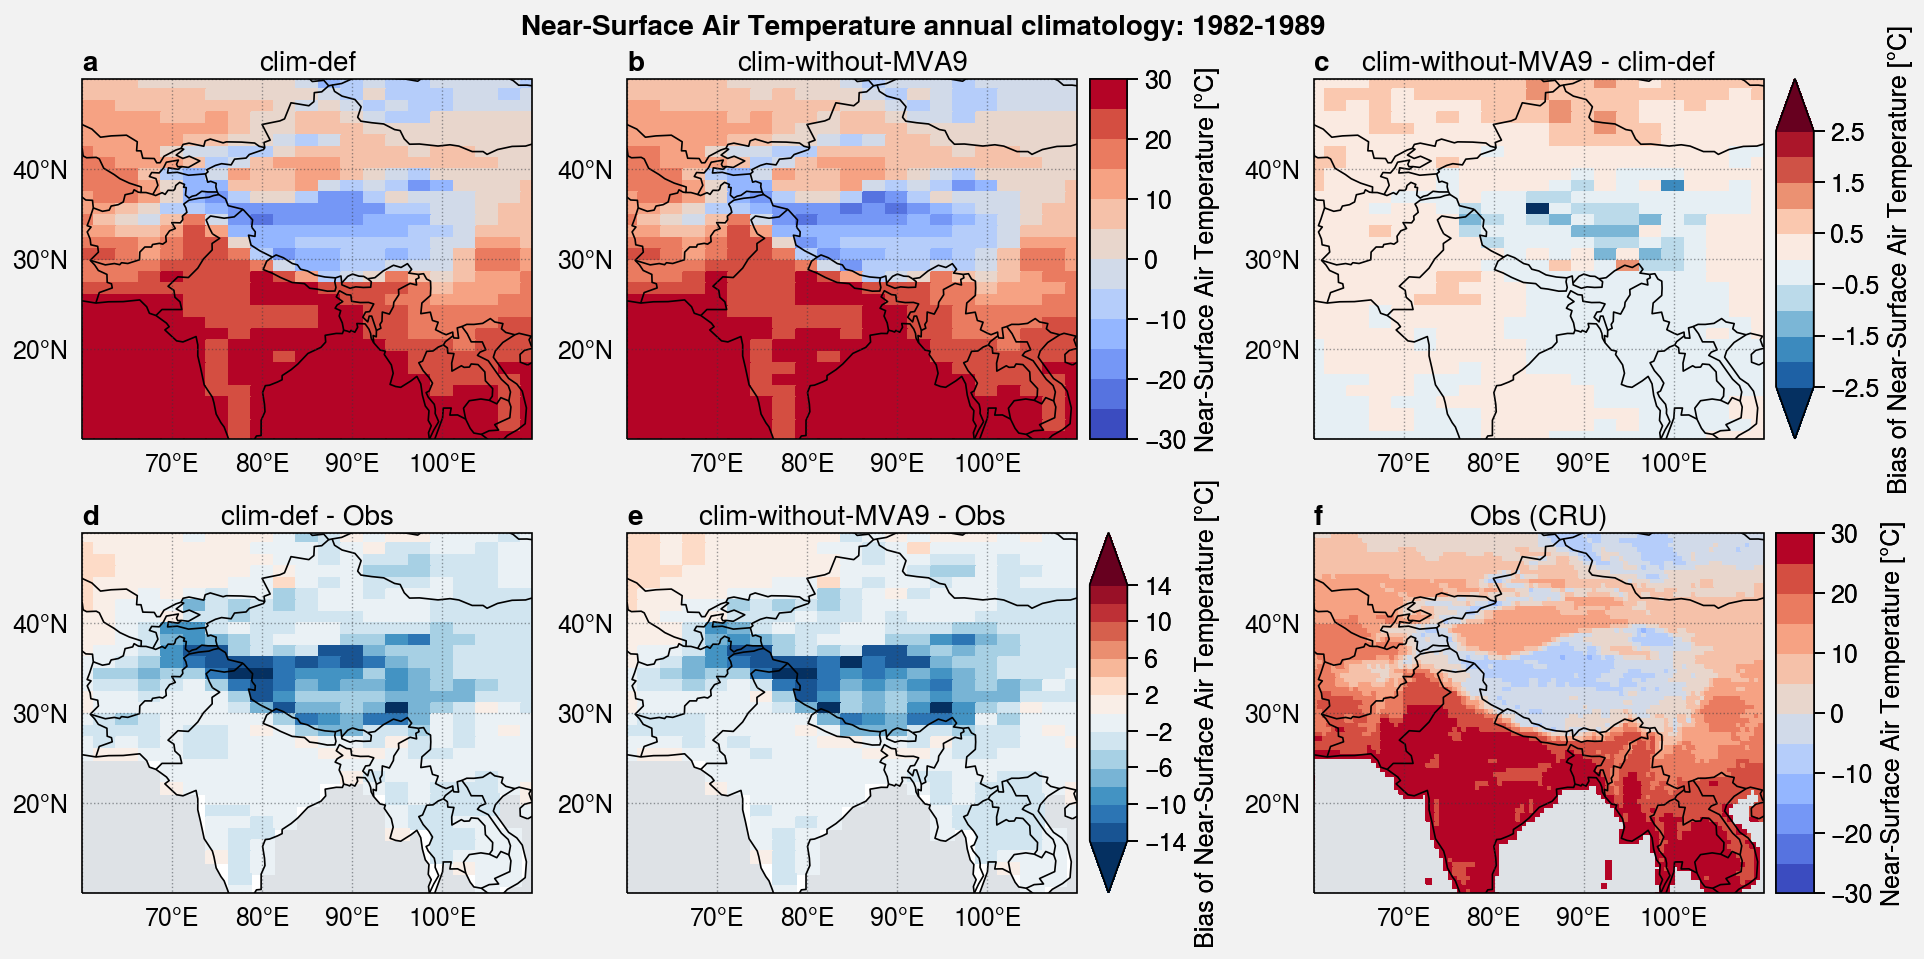

In [22]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=2)

levels_diff = plot.arange(-2.5,2.5,0.5)
cmap_diff = 'BuRd'
extend_diff = 'both'

levels_bias = plot.arange(-14,14,2)
cmap_bias = 'BuRd'
extend_bias = 'both'

# First row: differences
axs[0].pcolormesh(model_1_clim, cmap=cmap, levels=levels)
axs[0].format(title=title_1)

m1 = axs[1].pcolormesh(model_2_clim, cmap=cmap, levels=levels)
axs[1].format(title=title_2)
axs[1].colorbar(m1, label=label+ ' ['+units+']')

m2 = axs[2].pcolormesh(model_2_clim - model_1_clim, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[2].format(title=title_2+' - '+title_1)
axs[2].colorbar(m2, label='Bias of '+label+ ' ['+units+']')


# Second row: bias with obs

m3 = axs[3].pcolormesh(model_1_clim - obs_clim_regrid, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
axs[3].format(title=title_1+' - Obs')

axs[4].pcolormesh(model_2_clim - obs_clim_regrid, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
axs[4].format(title=title_2+' - Obs')
axs[4].colorbar(m3, label='Bias of '+label+ ' ['+units+']')

axs[5].pcolormesh(obs_clim, cmap=cmap, levels=levels)
axs[5].format(title='Obs ('+obs_name+')')
axs[5].colorbar(m1, label=label+ ' ['+units+']')


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=label+" annual climatology: "+period.start+"-"+period.stop,
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

f.save('img/'+var+'_'+exp+'_'+period.start+'-'+period.stop+'.jpg')
f.save('img/'+var+'_'+exp+'_'+period.start+'-'+period.stop+'.png')
f.save('img/'+var+'_'+exp+'_'+period.start+'-'+period.stop+'.pdf')